In [98]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt

In [99]:
def get_price(tick,res):
    res=str(res)
    hist=requests.get('https://ftx.com/api/markets/'+tick+'-PERP/candles?resolution='+res+'&start_time='+'0'+'&limit=1000').json()
    hist=pd.DataFrame(hist['result'])
    hist.drop(['startTime'], axis = 1, inplace=True)
    return hist

def get_time(hist):
    aux=hist.copy(deep=True)
    aux['time'] = pd.to_datetime(aux['time'], unit='ms')
    aux.set_index('time', inplace=True)
    return aux

def get_initime(hist):
    aux=hist.copy(deep=True)
    aux['time'] = pd.to_datetime(aux['time'], unit='ms')
    return aux['time'][0]

In [100]:
def coint_test(tick1,tick2,res):
    A=get_price(tick1,res)
    B=get_price(tick2,res)
    if not get_initime(B)==get_initime(A):
        print('Different initial time')
        return 
    X = np.stack((np.log(A['close']), np.log(B['close'])), axis=0)
    cov=np.cov(X)
    covAB=cov[0,1]
    varA=cov[0,0]
    varB=cov[1,1]
    cor=covAB/(np.sqrt(varA*varB))
    lAB=covAB/varB #res=log(A)-lAB*log(B)
    lBA=covAB/varA #res=log(B)-lBA*log(A)
    spreadAB=np.log(A['close'])-lAB*np.log(B['close'])
    muAB=np.mean(spreadAB)
    spreadBA=np.log(B['close'])-lBA*np.log(A['close'])
    muBA=np.mean(spreadBA)
    return cor,lAB,lBA,muAB,muBA,spreadAB,spreadBA

def print_spread(tick1,tick2,res):
    aux=coint_test(tick1,tick2,res)
    if aux[1]>aux[2]:
        print('We are gonna use A-lAB*B with correlation='+str(aux[0])+' and lambda_AB='+str(aux[1]))
        plt.plot(aux[5]-aux[3])
    else :
        print('We are gonna use B-lBA*A with correlation='+str(aux[0])+' and lambda_BA='+str(aux[2]))
        plt.plot(aux[6]-aux[4])

We are gonna use A-lAB*B with correlation=0.8172486157377524 and lambda_AB=1.3409956255739273


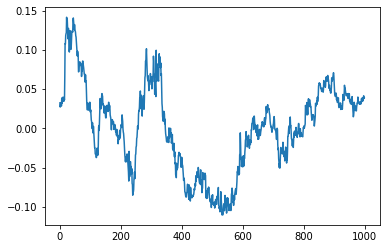

In [102]:
print_spread('SOL','ETH',3600)